In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
data_dir = Path("../raw_data/first_dataset_raw")
df_raw=pd.read_csv(data_dir/"BrainFlow-RAW_2025-05-19_22-02-06_79.csv", header=None, sep="\t")

In [3]:
print("Shape:", df_raw.shape)
df_raw.head()

Shape: (359078, 32)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,9664.782544,8370.527133,23299.301958,13937.698476,14454.761381,-3195.830070,4909.158338,-311.002172,0.0,...,104.0,0.0,0.0,16.0,8.0,0.0,0.0,0.0,1.747687e+09,0.0
1,2.0,19343.847852,16753.548891,46601.174367,27883.778856,28910.752107,-6409.340371,9889.283465,-623.144284,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.747687e+09,0.0
2,4.0,19340.629201,16741.031914,46604.683590,27885.879920,28939.384692,-6358.221931,9841.718953,-631.861464,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.747687e+09,0.0
3,6.0,19339.198689,16740.495472,46599.006247,27878.213272,28911.780287,-6401.763129,9834.991078,-624.641851,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.747687e+09,0.0
4,8.0,19340.182166,16742.752998,46605.935288,27887.757467,28924.520782,-6387.033330,9888.143526,-626.251176,0.0,...,112.0,0.0,8.0,16.0,24.0,0.0,0.0,0.0,1.747687e+09,0.0


In [4]:
df_raw.iloc[:, 1].describe()

count    359078.000000
mean      22144.245719
std        1119.423070
min        9664.782544
25%       21272.825750
50%       22143.470900
75%       23062.054954
max       24508.821906
Name: 1, dtype: float64

In [5]:
cols_to_drop = list(range(9, 11)) + list(range(17, 30))
df_raw = df_raw.drop(df_raw.columns[cols_to_drop], axis=1)

In [6]:
eeg_labels = ["Fp1", "Fp2", "C3", "C4", "T3", "T4", "O1", "O2", "F3", "F4", "Fz", "Pz", "P3", "P4"]
col_names = ["sample_index"] + eeg_labels + ["timestamp", "marker"]
df_raw.columns = col_names

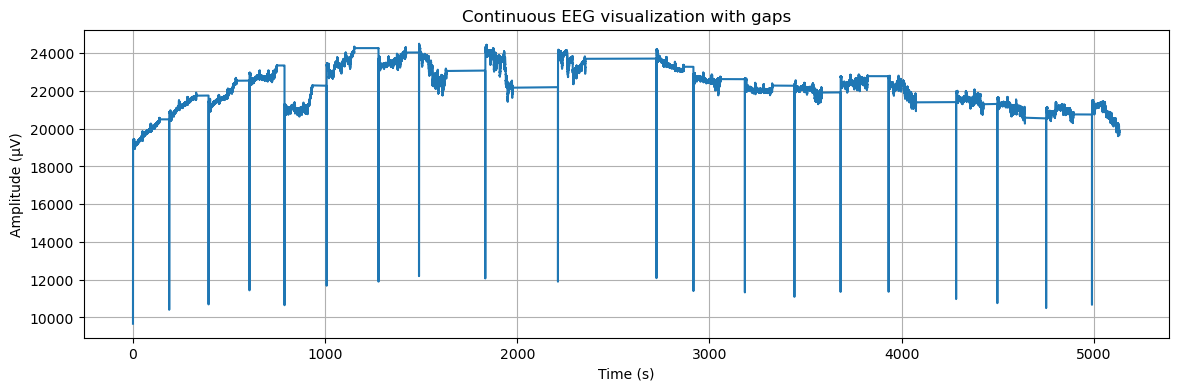

In [7]:
df_raw["time_sec"] = df_raw["timestamp"] - df_raw["timestamp"].iloc[0]

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 4))
plt.plot(df_raw["time_sec"], df_raw.iloc[:, 1])  # channel 0 (Fp1)
plt.title("Continuous EEG visualization with gaps")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.grid(True)
plt.show()

In [8]:
df_raw["timestamp_diff"] = df_raw["timestamp"].diff()
gap_threshold = 1.0  # seconds
gap_indices = df_raw.index[df_raw["timestamp_diff"] > gap_threshold].tolist()
print(gap_indices)

[17581, 35444, 53701, 71777, 89925, 108181, 126188, 144054, 161919, 179935, 197909, 215733, 233878, 251767, 269641, 287542, 305345, 323361, 341275]


In [9]:
def split_by_timestamp_gap(df, timestamp_col="timestamp", max_gap=1.0):
    df = df.copy()
    df["timestamp_diff"] = df[timestamp_col].diff()
    split_indices = df.index[df["timestamp_diff"] > max_gap].tolist()

    blocks = []
    start = 0
    for idx in split_indices:
        blocks.append(df.iloc[start:idx].reset_index(drop=True))
        start = idx
    blocks.append(df.iloc[start:].reset_index(drop=True))

    return blocks

In [10]:
blocks = split_by_timestamp_gap(df_raw, max_gap=1.0)

print(f"Number of detected blocks: {len(blocks)}")
for i, b in enumerate(blocks):
    duration = b["timestamp"].iloc[-1] - b["timestamp"].iloc[0]
    print(f"Block {i+1}: {len(b)} samples | {duration:.2f} s")


Number of detected blocks: 20
Block 1: 17581 samples | 140.57 s
Block 2: 17863 samples | 142.92 s
Block 3: 18257 samples | 146.04 s
Block 4: 18076 samples | 144.59 s
Block 5: 18148 samples | 145.16 s
Block 6: 18256 samples | 146.06 s
Block 7: 18007 samples | 144.08 s
Block 8: 17866 samples | 142.91 s
Block 9: 17865 samples | 142.95 s
Block 10: 18016 samples | 144.16 s
Block 11: 17974 samples | 143.79 s
Block 12: 17824 samples | 142.58 s
Block 13: 18145 samples | 145.17 s
Block 14: 17889 samples | 143.11 s
Block 15: 17874 samples | 142.99 s
Block 16: 17901 samples | 143.25 s
Block 17: 17803 samples | 142.44 s
Block 18: 18016 samples | 144.15 s
Block 19: 17914 samples | 143.31 s
Block 20: 17803 samples | 142.46 s


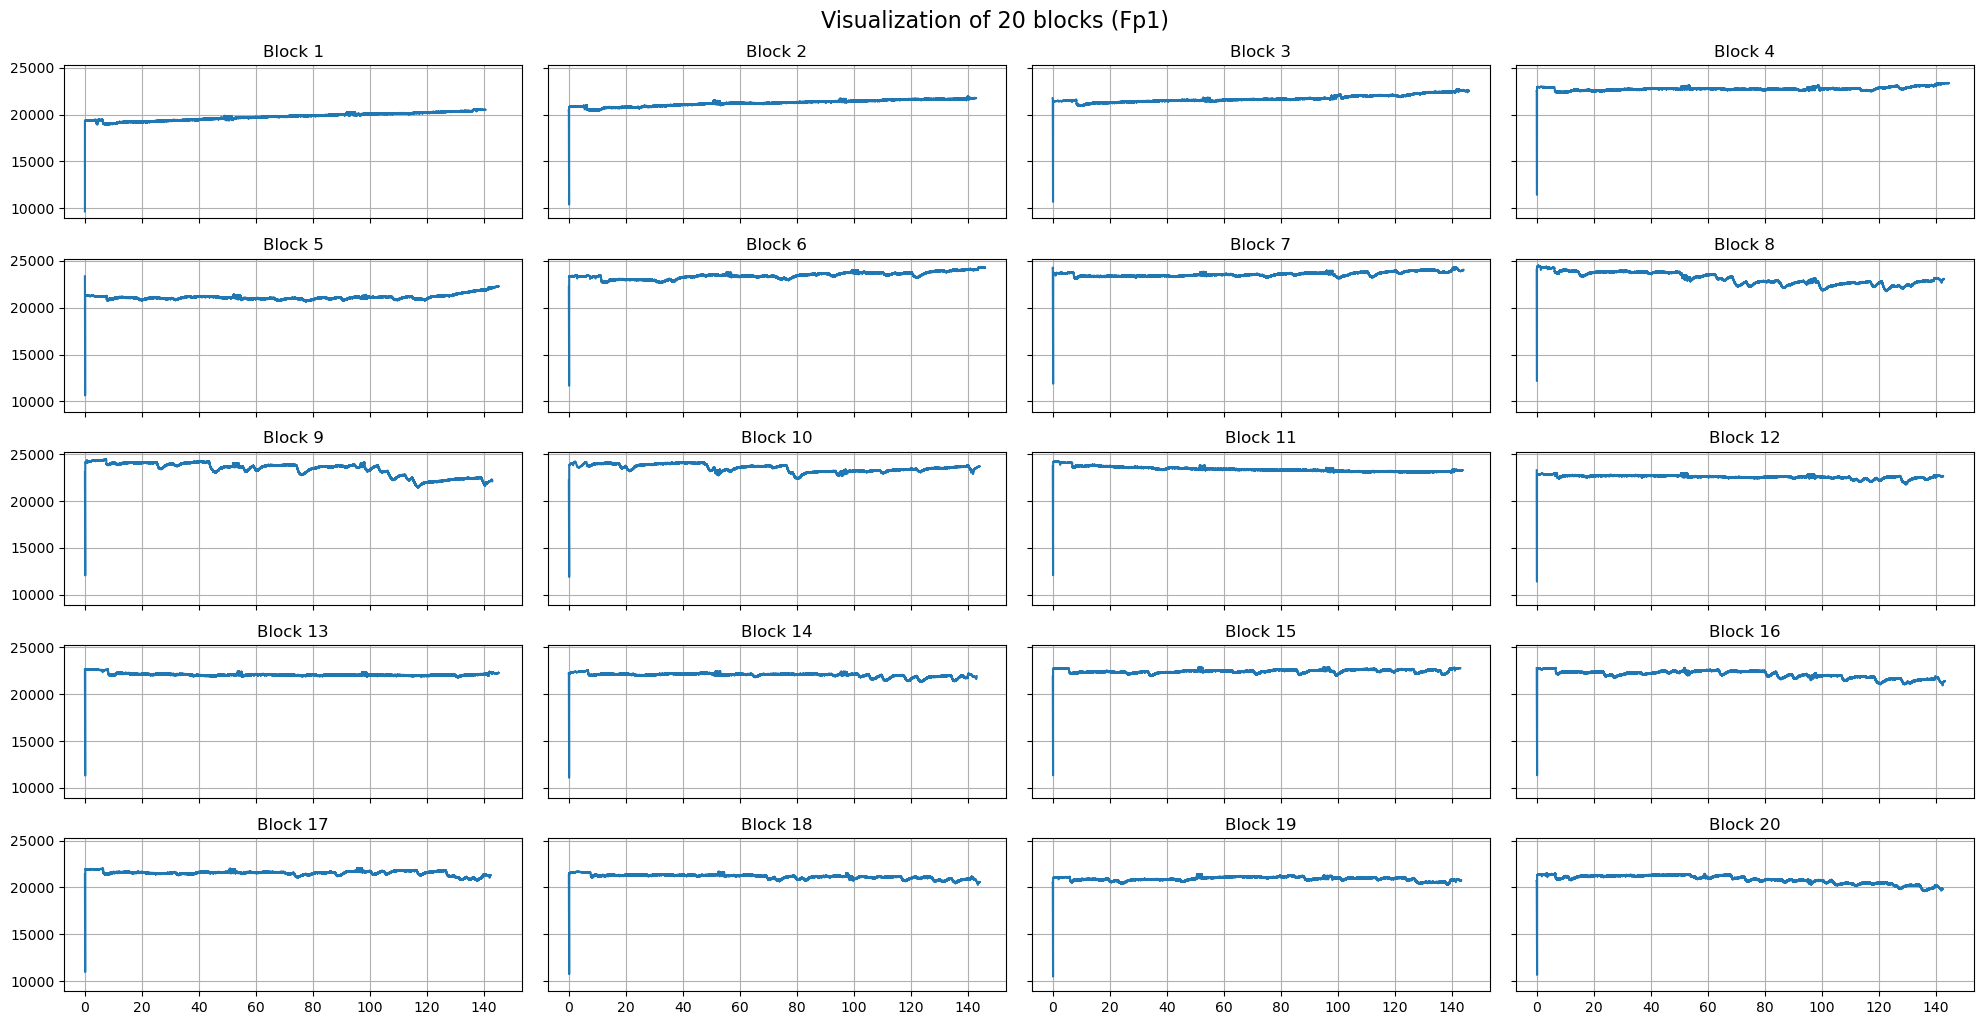

In [11]:
fig, axs = plt.subplots(5, 4, figsize=(20, 10), sharex=True, sharey=True)
axs = axs.flatten()

for i, df_block in enumerate(blocks):
    df_block["time_sec"] = df_block["timestamp"] - df_block["timestamp"].iloc[0]
    axs[i].plot(df_block["time_sec"], df_block["Fp1"])
    axs[i].set_title(f"Block {i+1}")
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Visualization of 20 blocks (Fp1)", fontsize=16, y=1.02)
plt.show()

In [12]:
def trim_block_by_timestamp(df, start_trim=7, end_trim=3):
    df = df.copy()
    start_time = df["timestamp"].iloc[0] + start_trim
    end_time = df["timestamp"].iloc[-1] - end_trim
    return df[(df["timestamp"] >= start_time) & (df["timestamp"] <= end_time)].reset_index(drop=True)

In [13]:
trimmed_blocks = [trim_block_by_timestamp(b) for b in blocks]

In [14]:
for i, b in enumerate(trimmed_blocks):
    dur = b["timestamp"].iloc[-1] - b["timestamp"].iloc[0]
    print(f"Block {i+1}: {dur:.2f} s")


Block 1: 130.56 s
Block 2: 132.90 s
Block 3: 136.03 s
Block 4: 134.58 s
Block 5: 135.16 s
Block 6: 136.05 s
Block 7: 134.07 s
Block 8: 132.90 s
Block 9: 132.94 s
Block 10: 134.15 s
Block 11: 133.77 s
Block 12: 132.57 s
Block 13: 135.17 s
Block 14: 133.10 s
Block 15: 132.98 s
Block 16: 133.23 s
Block 17: 132.43 s
Block 18: 134.14 s
Block 19: 133.30 s
Block 20: 132.45 s


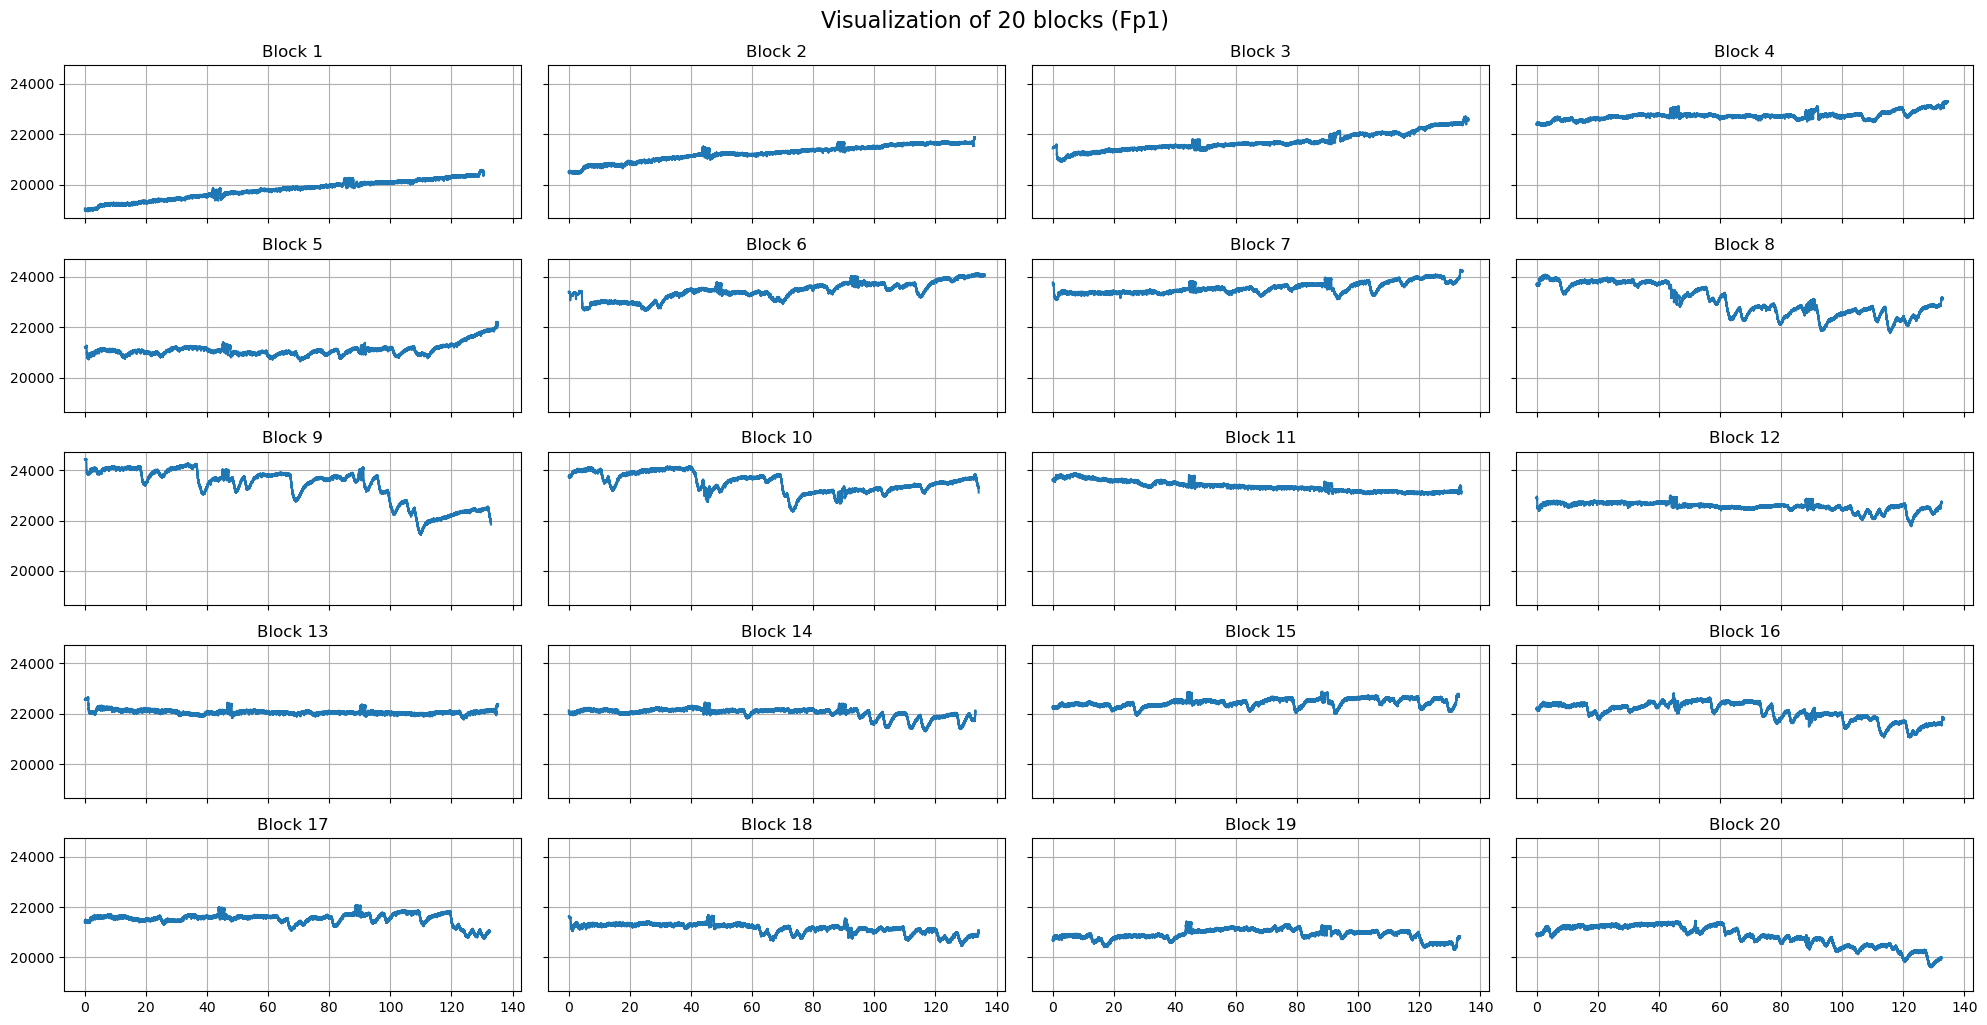

In [15]:
fig, axs = plt.subplots(5, 4, figsize=(20, 10), sharex=True, sharey=True)
axs = axs.flatten()

for i, df_block in enumerate(trimmed_blocks):
    df_block["time_sec"] = df_block["timestamp"] - df_block["timestamp"].iloc[0]
    axs[i].plot(df_block["time_sec"], df_block["Fp1"])
    axs[i].set_title(f"Block {i+1}")
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Visualization of 20 blocks (Fp1)", fontsize=16, y=1.02)
plt.show()

In [16]:
def save_trimmed_blocks(blocks, base_dir):
    output_dir = Path(base_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for i, block in enumerate(blocks, 1):
        filename = f"block_{i:02d}.pkl"
        path = output_dir / filename
        block.to_pickle(path)
        print(f"✅ Block {i} saved at {path}")


In [17]:
clean_dir = data_dir.parent / "first_dataset_trimmed_clean"
save_trimmed_blocks(trimmed_blocks, base_dir=clean_dir)

✅ Block 1 saved at ../raw_data/first_dataset_trimmed_clean/block_01.pkl
✅ Block 2 saved at ../raw_data/first_dataset_trimmed_clean/block_02.pkl
✅ Block 3 saved at ../raw_data/first_dataset_trimmed_clean/block_03.pkl
✅ Block 4 saved at ../raw_data/first_dataset_trimmed_clean/block_04.pkl
✅ Block 5 saved at ../raw_data/first_dataset_trimmed_clean/block_05.pkl
✅ Block 6 saved at ../raw_data/first_dataset_trimmed_clean/block_06.pkl
✅ Block 7 saved at ../raw_data/first_dataset_trimmed_clean/block_07.pkl
✅ Block 8 saved at ../raw_data/first_dataset_trimmed_clean/block_08.pkl
✅ Block 9 saved at ../raw_data/first_dataset_trimmed_clean/block_09.pkl
✅ Block 10 saved at ../raw_data/first_dataset_trimmed_clean/block_10.pkl
✅ Block 11 saved at ../raw_data/first_dataset_trimmed_clean/block_11.pkl
✅ Block 12 saved at ../raw_data/first_dataset_trimmed_clean/block_12.pkl
✅ Block 13 saved at ../raw_data/first_dataset_trimmed_clean/block_13.pkl
✅ Block 14 saved at ../raw_data/first_dataset_trimmed_clean/

In [18]:
def save_trimmed_blocks_csv(blocks, base_dir):
    output_dir = Path(base_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for i, block in enumerate(blocks, 1):
        filename = f"block_{i:02d}.csv"
        path = output_dir / filename
        block.to_csv(path, index=False)
        print(f"Block {i} saved as CSV at {path}")


In [19]:
clean_dir = data_dir.parent / "first_dataset_trimmed_clean"
save_trimmed_blocks_csv(blocks, base_dir=clean_dir)

Block 1 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_01.csv
Block 2 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_02.csv
Block 3 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_03.csv
Block 4 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_04.csv
Block 5 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_05.csv
Block 6 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_06.csv
Block 7 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_07.csv
Block 8 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_08.csv
Block 9 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_09.csv
Block 10 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_10.csv
Block 11 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_11.csv
Block 12 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_12.csv
Block 13 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_13